/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Accuracy: 1.00
Testing Accuracy: 0.92
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        67
           1       0.94      0.94      0.94        69
           2       0.91      0.91      0.91        56
           3       0.90      0.89      0.90        74
           4       0.90      0.91      0.90        77

    accuracy                           0.92       343
   macro avg       0.92      0.92      0.92       343
weighted avg       0.92      0.92      0.92       343



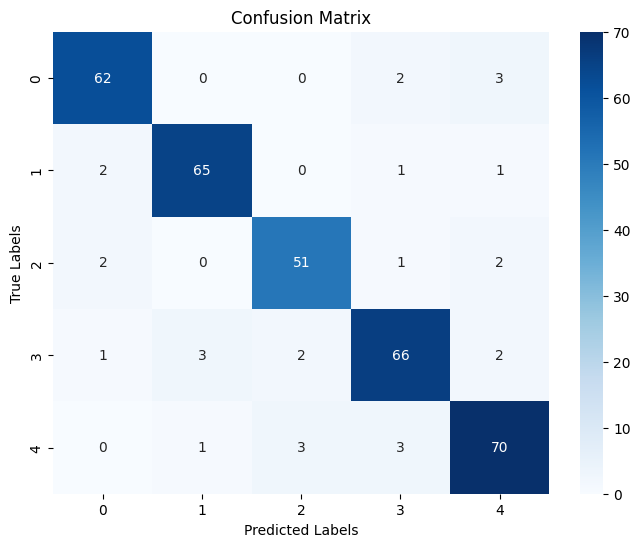


False Negative Rates for Each Class:
Class 0: FNR = 0.07
Class 1: FNR = 0.06
Class 2: FNR = 0.09
Class 3: FNR = 0.11
Class 4: FNR = 0.09
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


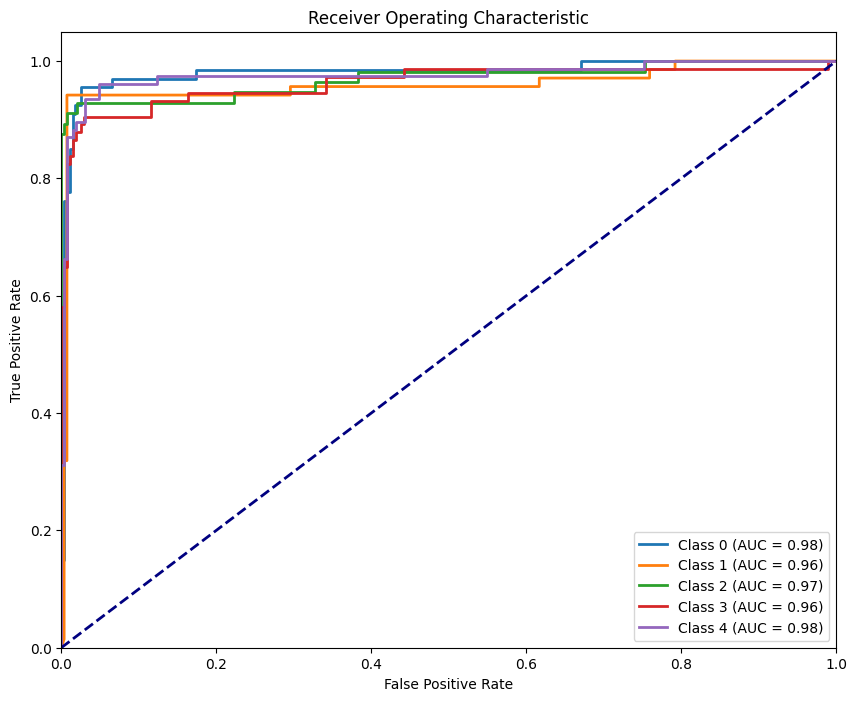

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the training dataset
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)

# Split features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Define the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.0009)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[lr_reduction], verbose=0,)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_combined, y_test_combined, verbose=0)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")

# Predict and evaluate performance
y_test_pred_combined = np.argmax(model.predict(X_test_combined), axis=1)

# Generate classification report
classes = np.unique(y_test_combined)
report = classification_report(y_test_combined, y_test_pred_combined, target_names=classes.astype(str))
print("\nClassification Report:\n", report)


# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
plot_confusion_matrix(cm_combined, classes)

# False Negative Rate for each class
fn_rate_per_class = []
for i in range(len(cm_combined)):
    FN = sum(cm_combined[i, :]) - cm_combined[i, i]
    TP = cm_combined[i, i]
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    fn_rate_per_class.append(FNR)

# Print FNR for each class
print("\nFalse Negative Rates for Each Class:")
for i, fnr in enumerate(fn_rate_per_class):
    print(f"Class {classes[i]}: FNR = {fnr:.2f}")

# ROC Curve
plt.figure(figsize=(10, 8))
y_test_prob_combined = model.predict(X_test_combined)
for i, cls in enumerate(range(len(classes))):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




In [ ]:
model.save('my_trained_model.h5')


In [ ]:
pip install scikeras


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


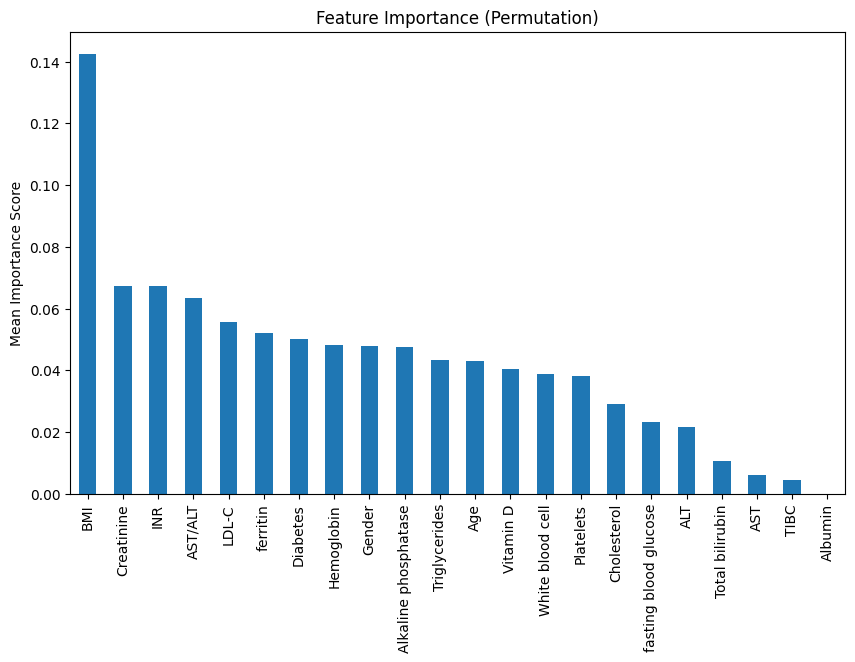

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance

# Wrap the Keras model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

wrapped_model = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)
wrapped_model.fit(X_train, y_train)

# Compute permutation importance
result = permutation_importance(wrapped_model, X_test_combined, y_test_combined, n_repeats=10, random_state=42)

# Plot feature importance
feature_importance = pd.Series(result.importances_mean, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Permutation)')
plt.ylabel('Mean Importance Score')
plt.show()



Top Features for Class 0:
Albumin: 0.0015
fasting blood glucose: -0.0017
AST: -0.0020
Hemoglobin: -0.0023
Cholesterol: -0.0041
Vitamin D: -0.0047
TIBC: -0.0052
Total bilirubin: -0.0058
ferritin: -0.0064
Creatinine: -0.0067
Diabetes: -0.0085
Gender: -0.0087
ALT: -0.0087
White blood cell: -0.0105
Age: -0.0111
LDL-C: -0.0120
Triglycerides: -0.0137
INR: -0.0157
AST/ALT: -0.0181
Alkaline phosphatase: -0.0207
Platelets: -0.0213
BMI: -0.0411


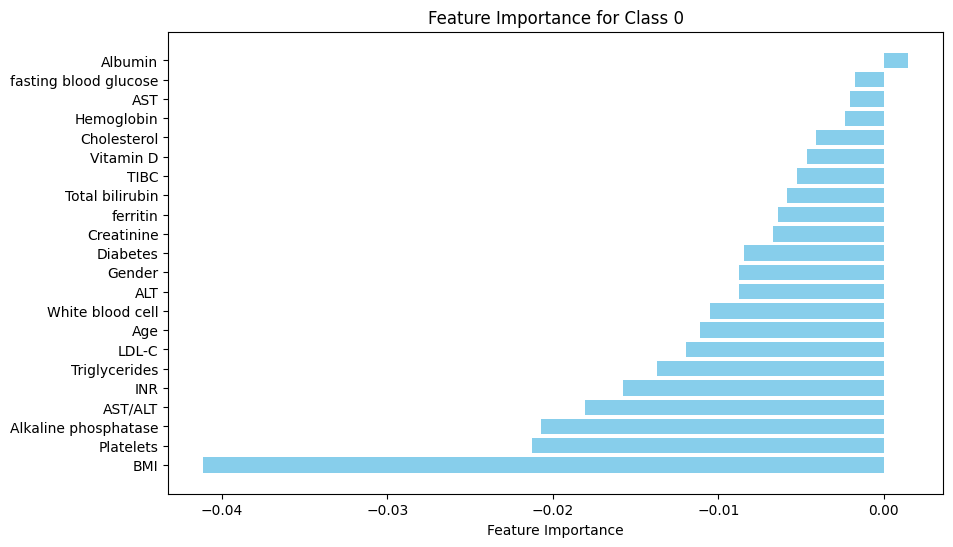


Top Features for Class 1:
Hemoglobin: 0.0268
Creatinine: 0.0210
AST/ALT: 0.0201
LDL-C: 0.0192
INR: 0.0187
Alkaline phosphatase: 0.0157
fasting blood glucose: 0.0102
Cholesterol: 0.0099
Triglycerides: 0.0076
Diabetes: 0.0073
Vitamin D: 0.0067
White blood cell: 0.0029
Albumin: 0.0026
AST: 0.0026
Age: 0.0020
BMI: 0.0015
Gender: 0.0009
Platelets: -0.0000
ferritin: -0.0000
Total bilirubin: -0.0023
TIBC: -0.0038
ALT: -0.0058


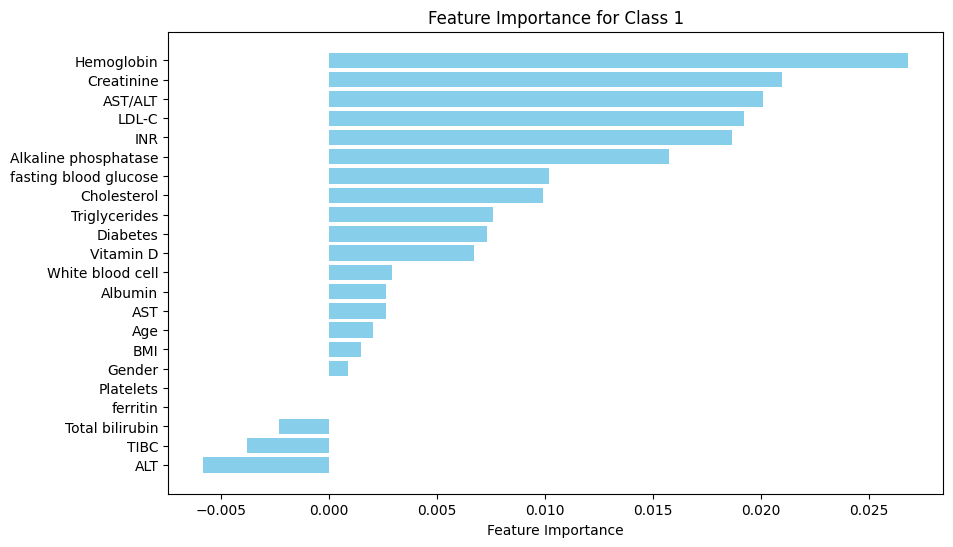


Top Features for Class 2:
Creatinine: 0.0259
Gender: 0.0090
fasting blood glucose: 0.0090
Cholesterol: 0.0079
Hemoglobin: 0.0079
Triglycerides: 0.0070
Diabetes: 0.0044
Vitamin D: 0.0032
Age: 0.0020
AST: -0.0003
White blood cell: -0.0012
Albumin: -0.0015
Platelets: -0.0023
TIBC: -0.0026
ALT: -0.0032
ferritin: -0.0035
Total bilirubin: -0.0052
LDL-C: -0.0058
BMI: -0.0082
INR: -0.0099
AST/ALT: -0.0105
Alkaline phosphatase: -0.0172


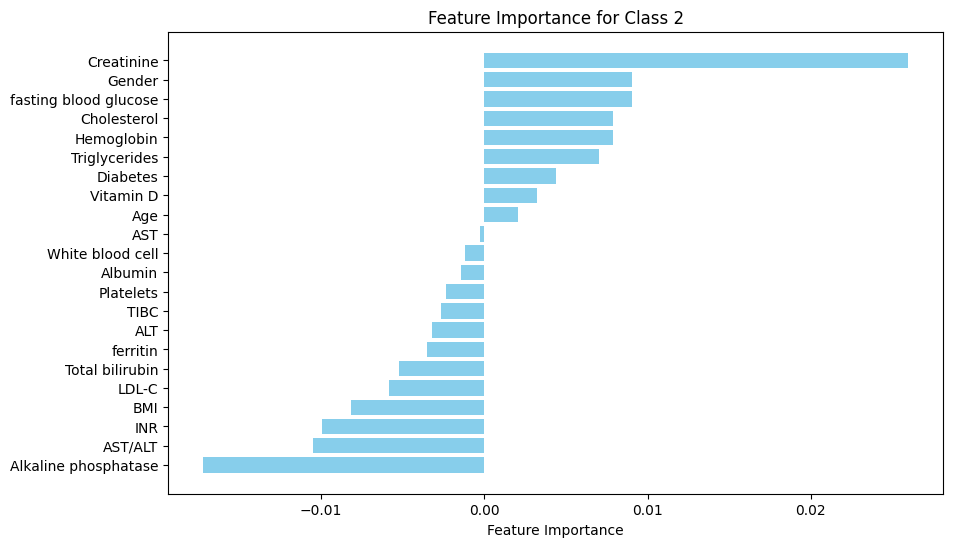


Top Features for Class 3:
Triglycerides: 0.0184
Creatinine: 0.0166
fasting blood glucose: 0.0070
BMI: 0.0061
Hemoglobin: 0.0052
Cholesterol: 0.0038
Diabetes: 0.0029
Age: 0.0020
Vitamin D: 0.0003
Albumin: -0.0003
ferritin: -0.0006
Gender: -0.0009
White blood cell: -0.0012
AST: -0.0029
TIBC: -0.0052
ALT: -0.0052
Total bilirubin: -0.0058
Platelets: -0.0061
LDL-C: -0.0082
INR: -0.0108
AST/ALT: -0.0128
Alkaline phosphatase: -0.0175


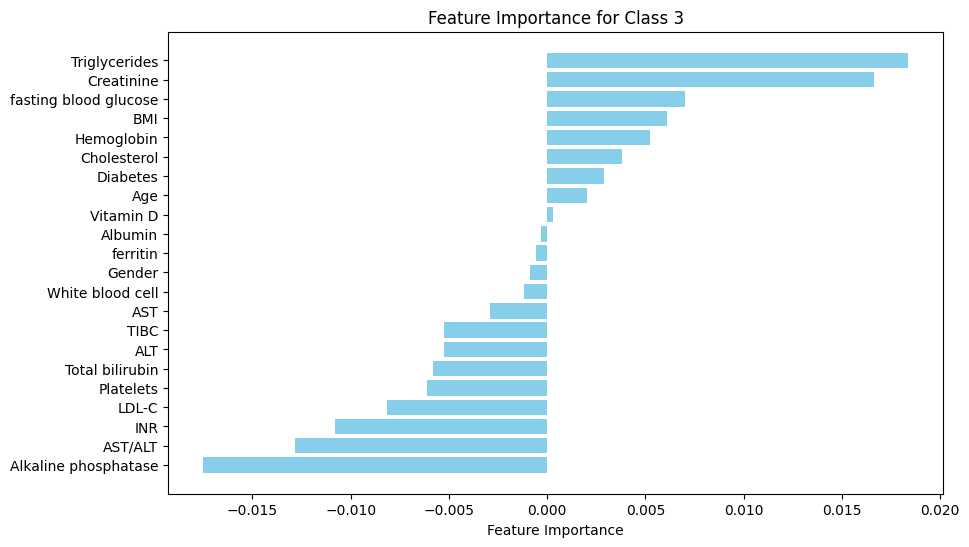


Top Features for Class 4:
BMI: 0.0230
Creatinine: 0.0213
Hemoglobin: 0.0114
fasting blood glucose: 0.0090
Triglycerides: 0.0076
Cholesterol: 0.0073
ferritin: 0.0073
Age: 0.0073
Vitamin D: 0.0064
Albumin: 0.0041
White blood cell: 0.0029
Diabetes: 0.0015
Gender: 0.0000
AST: -0.0006
ALT: -0.0026
Total bilirubin: -0.0032
LDL-C: -0.0032
TIBC: -0.0035
AST/ALT: -0.0052
Platelets: -0.0076
INR: -0.0166
Alkaline phosphatase: -0.0172


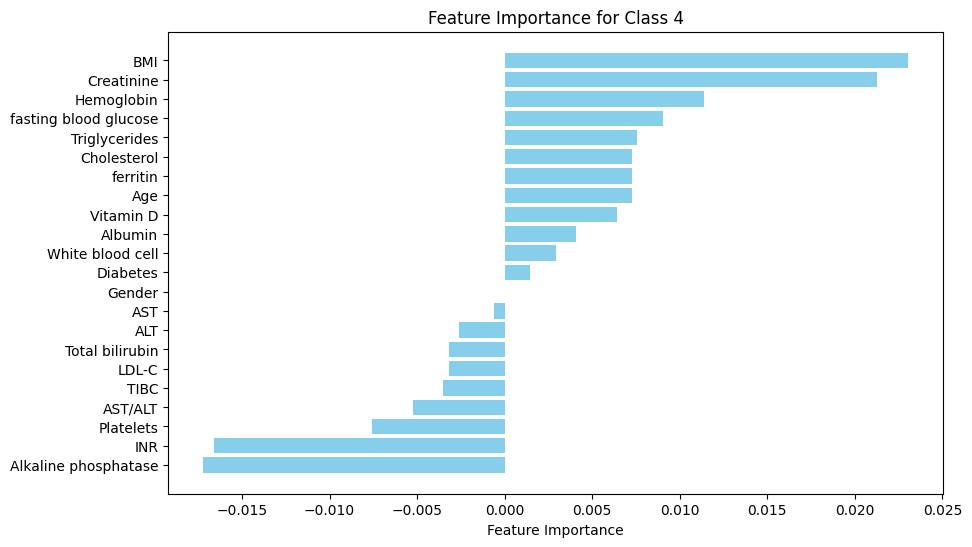

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Define a custom scoring function for the Keras model
def keras_score(model, X, y, sample_weight=None):
    _, acc = model.evaluate(X, y, verbose=0)
    return acc

# Get the unique classes
classes = np.unique(y_test_combined)

# Calculate feature importance for each class
for class_index, cls in enumerate(classes):
    # Binary target for the current class (1 for current class, 0 for others)
    y_binary = (y_test_combined == cls).astype(int)

    # Calculate permutation importance for the current class
    result = permutation_importance(model, X_test_combined, y_binary,
                                    n_repeats=10, random_state=42, scoring=keras_score)

    # Get importance scores and sort them
    importance_scores = result.importances_mean
    sorted_idx = np.argsort(importance_scores)[::-1]  # Sort in descending order
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Print important features for the current class
    print(f"\nTop Features for Class {cls}:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance for the current class
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls}')
    plt.show()
